# Forest Fire Prediction



In [1288]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [1289]:
# Importing python libraries for the various ML processess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
import pickle
import itertools

# Importing data from various sources
We will be importing two datasets here. 

 

1. The first dataset represents the Dataset that is collected from various parts of california in order to access the various incidents and reports related to forest fire event.

2. The second dataset is the weather data set is downloaded from the **RIVERSIDE MUNICIPAL AIRPORT, CA US** Weather Center(This station can be found on [NOAA Website](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00003171/detail)). The data available in these weather station range from April,1998 to current date. 

We will be performing an exploratory analysis in order to visualize our data and draw intuitive insights from it.



In [1290]:
# Data import for California Wildfire Data
dfCaliData =  pd.read_csv('./data/CaliDataWithCounty.csv')

# Data import for the Riverside Muni weather station
dfWeatherData = pd.read_csv('./data/USW00003171.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1291]:
dfCaliData.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,NewCountyValue
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1.0,PNF-47,BJ8K,FOUNTAIN,NaN,NaN,NaN,NaN,NaN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,Plumas County
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13.0,13,AAC0,PIGEON,NaN,NaN,NaN,NaN,NaN,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,El Dorado County
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27.0,021,A32W,SLACK,NaN,NaN,NaN,NaN,NaN,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,El Dorado County
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43.0,6,NaN,DEER,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,Alpine County
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44.0,7,NaN,STEVENOT,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,Alpine County


In [1292]:
dfCaliData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189550 entries, 0 to 189549
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   OBJECTID                    189550 non-null  int64  
 1   FOD_ID                      189550 non-null  int64  
 2   FPA_ID                      189550 non-null  object 
 3   SOURCE_SYSTEM_TYPE          189550 non-null  object 
 4   SOURCE_SYSTEM               189550 non-null  object 
 5   NWCG_REPORTING_AGENCY       189550 non-null  object 
 6   NWCG_REPORTING_UNIT_ID      189550 non-null  object 
 7   NWCG_REPORTING_UNIT_NAME    189550 non-null  object 
 8   SOURCE_REPORTING_UNIT       189550 non-null  object 
 9   SOURCE_REPORTING_UNIT_NAME  189550 non-null  object 
 10  LOCAL_FIRE_REPORT_ID        61933 non-null   float64
 11  LOCAL_INCIDENT_ID           127983 non-null  object 
 12  FIRE_CODE                   55522 non-null   object 
 13  FIRE_NAME     

From the above information we can see that the pre-filtered California data that we have has 40 different values. Out of which there are multiple ID's that are unique identifier and are just increasing the dimentionality of our data. So in order to get rid of this, we will remove those values from our data.

We also see that we have some data related to **FIRE_SIZE** and **FIRE_SIZE_CLASS** these two columns can be beneficial for us in order to correlate the weather data along with the location.

# Identifying columns from California Wildfire Data that is not relevant for the Analysis

In [1293]:
columns = dfCaliData.columns
totalRows = len(dfCaliData)

for col in columns:
  print(col)
  print('Total Records',len(dfCaliData[col]))
  print('Unique Records', len(dfCaliData[col].unique()))

OBJECTID
Total Records 189550
Unique Records 189550
FOD_ID
Total Records 189550
Unique Records 189550
FPA_ID
Total Records 189550
Unique Records 189549
SOURCE_SYSTEM_TYPE
Total Records 189550
Unique Records 3
SOURCE_SYSTEM
Total Records 189550
Unique Records 6
NWCG_REPORTING_AGENCY
Total Records 189550
Unique Records 8
NWCG_REPORTING_UNIT_ID
Total Records 189550
Unique Records 134
NWCG_REPORTING_UNIT_NAME
Total Records 189550
Unique Records 134
SOURCE_REPORTING_UNIT
Total Records 189550
Unique Records 165
SOURCE_REPORTING_UNIT_NAME
Total Records 189550
Unique Records 202
LOCAL_FIRE_REPORT_ID
Total Records 189550
Unique Records 10137
LOCAL_INCIDENT_ID
Total Records 189550
Unique Records 65762
FIRE_CODE
Total Records 189550
Unique Records 23682
FIRE_NAME
Total Records 189550
Unique Records 78147
ICS_209_INCIDENT_NUMBER
Total Records 189550
Unique Records 2253
ICS_209_NAME
Total Records 189550
Unique Records 1828
MTBS_ID
Total Records 189550
Unique Records 1068
MTBS_FIRE_NAME
Total Record

From the above we see that below mentioned column data are purely IDs(Unique Identifiers) those are:-


1.   OBJECTID
2.   FOD_ID
3.   FPA_ID

Being used purely as unique Identifier they are just increasing the dimentionality of the data. Hence we will drop them



# Extracting only the relevant information from the given California Wildfire data.
From the california wildfire data we just need few data points. This can be revisited later if the analysis requires more data.

In [1294]:
# Select the columns required for our analysis leaving others
dfCaliData = dfCaliData[['DISCOVERY_DATE','DISCOVERY_TIME','LATITUDE','LONGITUDE',
                         'STAT_CAUSE_DESCR','FIRE_SIZE','FIRE_SIZE_CLASS','NewCountyValue']]
dfCaliData.head()

,DISCOVERY_DATE,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue
0,2453403.5,1300.0,40.036944,-121.005833,Miscellaneous,0.10,A,Plumas County
1,2453137.5,845.0,38.933056,-120.404444,Lightning,0.25,A,El Dorado County
2,2453156.5,1921.0,38.984167,-120.735556,Debris Burning,0.10,A,El Dorado County
3,2453184.5,1600.0,38.559167,-119.913333,Lightning,0.10,A,Alpine County
4,2453184.5,1600.0,38.559167,-119.933056,Lightning,0.10,A,Alpine County


### Converting the date to julian format
The given date in `DISCOVERY_DATE` column is not in correct format. We need to convert it to Julian Format so that the date is readable. The format of the date is `yyyy-mm-dd` and the column has a datatype of datetime64

In [1295]:
# Lets convert the Discovery Date to Proper Date
dfCaliData['DATE'] = pd.to_datetime(dfCaliData['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

# Adding Month Column and Day of the week in order to Aid visualization
dfCaliData['MONTH'] = pd.DatetimeIndex(dfCaliData['DATE']).month
dfCaliData['DAY_OF_WEEK'] =  dfCaliData['DATE'].dt.strftime("%A") 

# Drop the DISCOVERY_DATE column as the DATE column already holds the required data
dfCaliData = dfCaliData.drop(['DISCOVERY_DATE'], axis=1)
dfCaliData.sample(3)

,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue,DATE,MONTH,DAY_OF_WEEK
92210,NaN,41.213889,-123.743889,Arson,3.0,B,NaN,1992-08-03,8,Monday
151365,1233.0,36.757479,-119.654099,Missing/Undefined,1.0,B,Fresno County,2011-08-27,8,Saturday
128926,NaN,33.263889,-117.216944,Children,0.1,A,San Diego County,1994-07-15,7,Friday


## Visualization of the California Forest Fire Data
Lets do some basic visualization of the forest fire data across california adn get a grasp of the following:-
1. What is causing the Forest Fire
2. Which months are prone to forest fire
3. Are weekends to play a role in the forest fire
4. Which are the counties most effected throughout the timeline
5. What are the causes of fire in the county with maximum fire events

Lets try to reason out these one by one. So that we are able to narrow down our data and also figure out the county most effected by forest fire.

### Cause of Wildfire in California
We will check the frequency of the wildfire with the causes that caused it.
Lets get the frequency count for the Cause of the wild fire

In [1296]:
dfCaliData['STAT_CAUSE_DESCR'].value_counts()

Miscellaneous        51943
Equipment Use        39407
Lightning            27000
Arson                19635
Debris Burning       14318
Missing/Undefined    12605
Campfire              9516
Children              6930
Smoking               5936
Powerline             1198
Railroad               720
Fireworks              219
Structure              123
Name: STAT_CAUSE_DESCR, dtype: int64

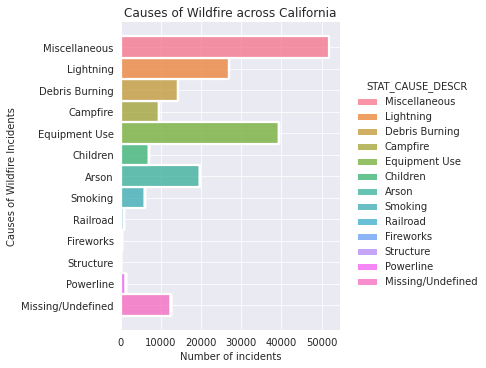

In [1297]:
# Graphical representation of the above data
g = sns.displot(data=dfCaliData,y="STAT_CAUSE_DESCR",hue="STAT_CAUSE_DESCR", multiple="stack").set(title='Causes of Wildfire across California')
plt.xlabel('Number of incidents')
plt.ylabel('Causes of Wildfire Incidents')

plt.show()

From the above data as well as the Graph it is evident that the major cause of wildfire is **Miscellaneous(unknown)** whereas the second largest cause is **Equipement usage(Caused by human intervention)**. As the list suggests **Lightening**, **Arson** and **Debris Burning** also contribute to the cause.

### Most active Months

The monthly analysis will show us which months are prone to wildfire incidents. These wildfire incidents increase from a period of May to Septemper, which mostly is a dry spell in California. We should also note that these months are the dry months in california.

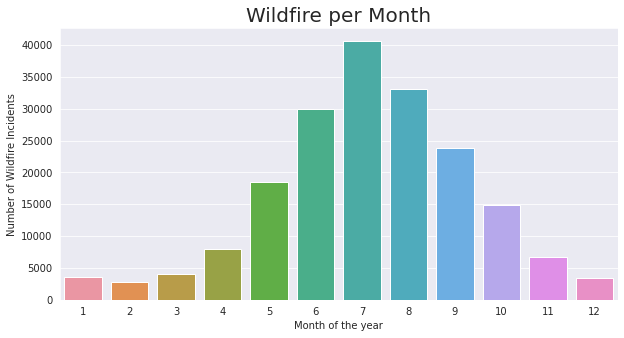

In [1298]:
# Graphical representation of the above data
dfMonth = dfCaliData.groupby(['MONTH']).size()
dfMonth = dfMonth.reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(10,5))
g = sns.barplot(data = dfMonth, y = 'count', x = 'MONTH')
plt.xlabel('Month of the year')
plt.ylabel('Number of Wildfire Incidents')
g.axes.set_title('Wildfire per Month',fontsize=20)
plt.show()

### Do weekends play a role in wildfire
We mostly see people outside during weekend and during summers people usually camp outside and being careful might be one of the reason for the Wildfire. Let's investigate if this is true.

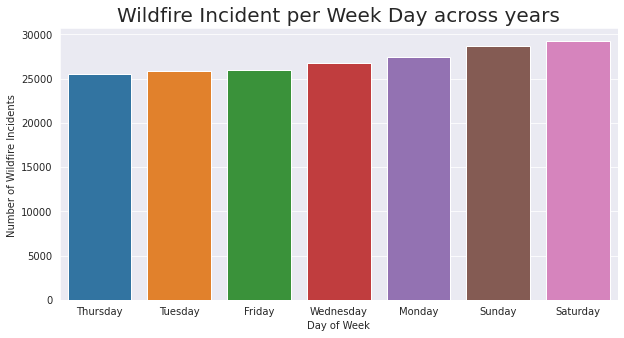

In [1299]:
# Graphical representation of the above data
dfDayOfWeek = dfCaliData.groupby(['DAY_OF_WEEK']).size()
dfDayOfWeek = dfDayOfWeek.reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(10,5))
g = sns.barplot(data = dfDayOfWeek, y = 'count', x = 'DAY_OF_WEEK')
plt.xlabel('Day of Week')
plt.ylabel('Number of Wildfire Incidents ')
g.axes.set_title('Wildfire Incident per Week Day across years',fontsize=20)
plt.show()

We see a gradual spike on the number of incidents that occour on weekly basis but not a significant increase. So we can say that weekends and public outing sometimes might lead to wildfire(due to careless activities) but this is not enough to conclude.

### Counties most effected by Wildfire
Here we use the same methodology and try to plot a bagraph to visulize the county with maximum fire event. We will group the data by county and then try to sort to find the values that are at the highest end or basically the tail of the data.

In [1300]:
# Grouping the data based on county and then sorting in increasing order to find the county with maximum Wildfire incident
dfCaliData.groupby(['NewCountyValue']).size().sort_values()

NewCountyValue
Sutter                       1
Tecate                       1
Jackson County               1
Tulare                       1
Shasta                       1
                         ...  
Tulare County             7918
Fresno County             8556
San Bernardino County     8562
San Diego County          9112
Riverside County         18823
Length: 81, dtype: int64

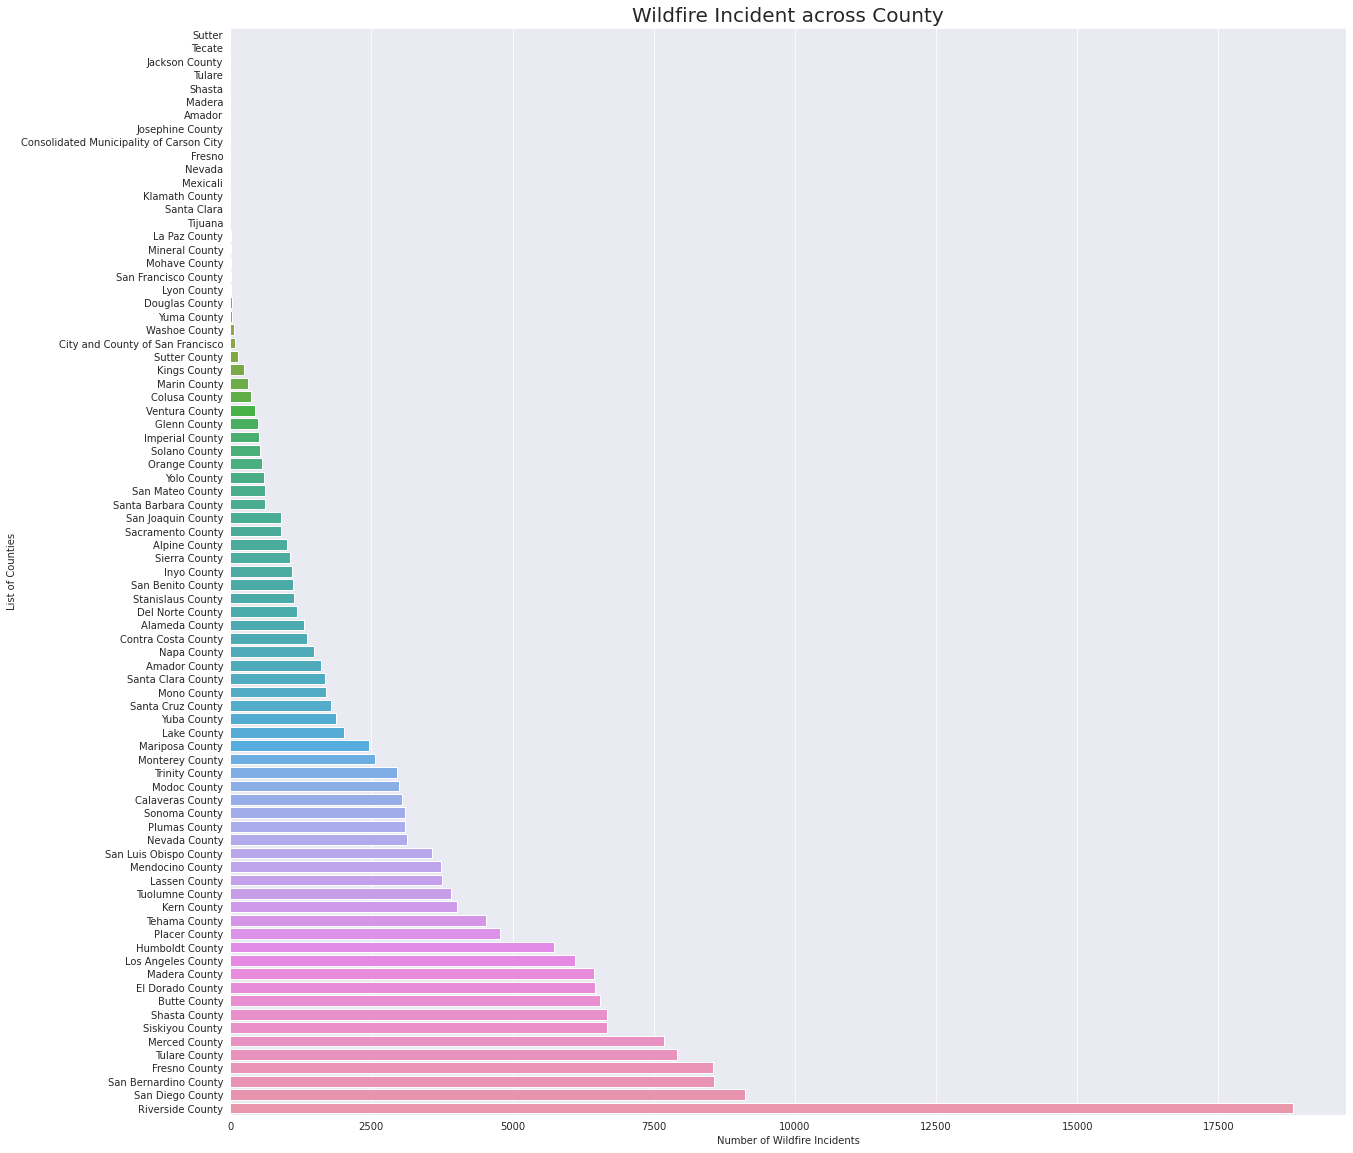

In [1301]:
# Plotting the wildfire incident across various county to see which county has the highest Wildfire Incident(We already
# know from the above that the Riverside County is worst effected.)

# Graphical representation of the above data
dfCounties = dfCaliData.groupby(['NewCountyValue']).size()
dfCounties = dfCounties.reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(20,20))
g = sns.barplot(data = dfCounties, y = 'NewCountyValue', x = 'count')
plt.xlabel('Number of Wildfire Incidents')
plt.ylabel('List of Counties')
g.axes.set_title('Wildfire Incident across County',fontsize=20)
plt.show()

### What are the causes of these events in Riverside County
The next visualization will tell us what are the causes of such Wildfire incidents in the **Riverside County**.

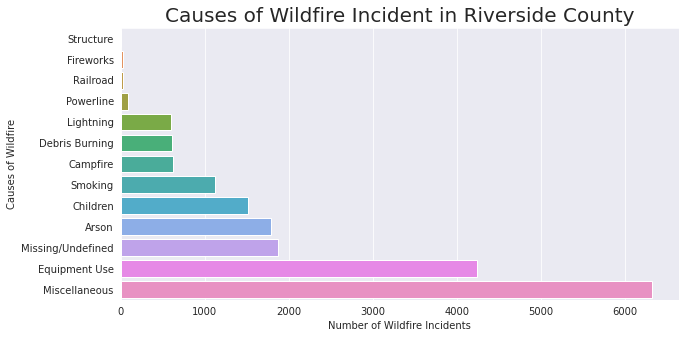

In [1302]:
# Graphical representation of the above data
dfCountyCauses = dfCaliData.loc[dfCaliData['NewCountyValue'] == 'Riverside County'].groupby(['STAT_CAUSE_DESCR']).size()
dfCountyCauses = dfCountyCauses.reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(10,5))
g = sns.barplot(data = dfCountyCauses, y = 'STAT_CAUSE_DESCR', x = 'count')
plt.xlabel('Number of Wildfire Incidents')
plt.ylabel('Causes of Wildfire')
g.axes.set_title('Causes of Wildfire Incident in Riverside County',fontsize=20)
plt.show()

Its very evident from the above that the major cause of a Wildfire incident in the Riverside County is mostly due to Miscellaneous factors. This also see that lightening contributes pretty low to this data. As we have initially assumed, as this data does not have any weather data we would like to further investigate and find the correlation between these event and whether weather has any role to play.

### Conclusion

From all the above we can conclude the following points.


1.   The leading cause of Wildfire is **Equipment usage**, **Lightening**, **Arson** and some **Miscellaneous** reasons. But all these reasons for sure leads to Wildfire.
2.   **July**, **August**, **September** and **October** are the most active months.
3. Weekends don't play a very significant role because its a really small change that we notice. On the other hand **Saturday** seems to have a large number of Wildfire incidents.
4. **Riverside County** had the most number of Wildfire events throughout the dataset.

From the above we infer that the Riverside County had the maximum numbe of fire events and can also narrow down our dataset to a specific county in order to do further analysis.


## Data Extraction and  Merge
As we already know that **Riverside county** has the maximum records of the fire incident, we will go ahead and extract the **Riverside County** Data from the California Wildfire Data and then sort it by `DATE`. This will enable us to prepare the data for merging it with the weather data. We will also add a new column `IS_WILDFIRE` to the data that will classify this as a positive datapoint.

In [1303]:
# As we see Riverside county has the maximum number of fire incidents we will pull out the data related to riverside county
dfRiverSideCounty = dfCaliData.loc[dfCaliData['NewCountyValue'] == 'Riverside County']
dfRiverSideCounty.head()

,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue,DATE,MONTH,DAY_OF_WEEK
25,1700.0,33.666667,-117.376389,Miscellaneous,0.1,A,Riverside County,2005-04-27,4,Wednesday
27,1500.0,33.718889,-117.433611,Equipment Use,10.0,C,Riverside County,2005-06-19,6,Sunday
170,1810.0,33.432778,-116.860278,Arson,0.1,A,Riverside County,2005-07-27,7,Wednesday
172,1255.0,33.611667,-116.871944,Lightning,6.0,B,Riverside County,2005-08-06,8,Saturday
266,1005.0,33.468611,-116.933056,Equipment Use,0.1,A,Riverside County,2005-06-21,6,Tuesday


In [1304]:
# Sorting based on Date
dfRiverSideCounty = dfRiverSideCounty.sort_values(by="DATE")
dfRiverSideCounty.head(10)

,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue,DATE,MONTH,DAY_OF_WEEK
135389,NaN,33.663889,-116.171944,Children,0.2,A,Riverside County,1992-01-01,1,Wednesday
135391,NaN,33.678056,-116.171944,Children,0.1,A,Riverside County,1992-01-02,1,Thursday
135390,NaN,33.896111,-116.990000,Miscellaneous,0.5,B,Riverside County,1992-01-02,1,Thursday
135393,NaN,33.996944,-117.426111,Miscellaneous,0.1,A,Riverside County,1992-01-04,1,Saturday
135392,NaN,33.808056,-117.268889,Miscellaneous,0.1,A,Riverside County,1992-01-04,1,Saturday
135394,NaN,33.865000,-117.373889,Campfire,0.1,A,Riverside County,1992-01-07,1,Tuesday
135395,NaN,33.793889,-117.251111,Miscellaneous,2.0,B,Riverside County,1992-01-12,1,Sunday
135396,NaN,33.821944,-117.338056,Debris Burning,0.3,B,Riverside County,1992-01-13,1,Monday
135398,NaN,33.561944,-116.068889,Campfire,0.5,B,Riverside County,1992-01-14,1,Tuesday
135397,NaN,33.938889,-117.268889,Children,0.1,A,Riverside County,1992-01-14,1,Tuesday


In [1305]:
# Adding a new column to the dataframe to signify the positive events
dfRiverSideCounty['IS_WILDFIRE'] = 1
dfRiverSideCounty.head(10)

,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue,DATE,MONTH,DAY_OF_WEEK,IS_WILDFIRE
135389,NaN,33.663889,-116.171944,Children,0.2,A,Riverside County,1992-01-01,1,Wednesday,1
135391,NaN,33.678056,-116.171944,Children,0.1,A,Riverside County,1992-01-02,1,Thursday,1
135390,NaN,33.896111,-116.990000,Miscellaneous,0.5,B,Riverside County,1992-01-02,1,Thursday,1
135393,NaN,33.996944,-117.426111,Miscellaneous,0.1,A,Riverside County,1992-01-04,1,Saturday,1
135392,NaN,33.808056,-117.268889,Miscellaneous,0.1,A,Riverside County,1992-01-04,1,Saturday,1
135394,NaN,33.865000,-117.373889,Campfire,0.1,A,Riverside County,1992-01-07,1,Tuesday,1
135395,NaN,33.793889,-117.251111,Miscellaneous,2.0,B,Riverside County,1992-01-12,1,Sunday,1
135396,NaN,33.821944,-117.338056,Debris Burning,0.3,B,Riverside County,1992-01-13,1,Monday,1
135398,NaN,33.561944,-116.068889,Campfire,0.5,B,Riverside County,1992-01-14,1,Tuesday,1
135397,NaN,33.938889,-117.268889,Children,0.1,A,Riverside County,1992-01-14,1,Tuesday,1


In [1306]:
dfRiverSideCounty.loc[dfRiverSideCounty['DATE'].duplicated()]

,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue,DATE,MONTH,DAY_OF_WEEK,IS_WILDFIRE
135390,NaN,33.896111,-116.990000,Miscellaneous,0.50,B,Riverside County,1992-01-02,1,Thursday,1
135392,NaN,33.808056,-117.268889,Miscellaneous,0.10,A,Riverside County,1992-01-04,1,Saturday,1
135397,NaN,33.938889,-117.268889,Children,0.10,A,Riverside County,1992-01-14,1,Tuesday,1
135399,NaN,33.940000,-116.988889,Equipment Use,0.10,A,Riverside County,1992-01-15,1,Wednesday,1
37257,2055.0,33.816700,-116.334200,Campfire,0.10,A,Riverside County,1992-01-25,1,Saturday,1
...,...,...,...,...,...,...,...,...,...,...,...
180989,1830.0,33.458184,-117.086954,Arson,0.10,A,Riverside County,2015-12-20,12,Sunday,1
180940,1912.0,33.758471,-117.189152,Missing/Undefined,0.10,A,Riverside County,2015-12-26,12,Saturday,1
180781,1636.0,33.696216,-117.314098,Miscellaneous,2.00,B,Riverside County,2015-12-26,12,Saturday,1
181080,844.0,33.515344,-114.568555,Missing/Undefined,0.01,A,Riverside County,2015-12-28,12,Monday,1


In [1307]:
# Removing the dulicate values based on date. We can in later point of time revisit this and figure things out
dfRiverSideCounty = dfRiverSideCounty.drop_duplicates(subset=['DATE'])

In [1308]:
len(dfRiverSideCounty)

6228

### Extracting weather data based on the columns that seem necessary
The various parameters that are available with us from the weather data perspective are as follows:-
1. TMAX - Maximum temperature (tenths of degrees C)
2. TMIN - Minimum temperature (tenths of degrees C)
3. PRCP - Precipitation (tenths of mm)
4. AWND - Average daily wind speed (tenths of meters per second)
5. FMTM - Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)
6. PGTM - Peak gust time (hours and minutes, i.e., HHMM)
7. TAVG - Average temperature (tenths of degrees C)(Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight)
8. WDF2 - Direction of fastest 2-minute wind (degrees)
9. WDF5 - Direction of fastest 5-second wind (degrees)
10. WSF2 - Fastest 2-minute wind speed (tenths of meters per second)
11. WSF5 - Fastest 5-second wind speed (tenths of meters per second)

From the above we will only take TMAX, TMIN, PRCP, AWND for our analysis

The above are available as a part of the [code book](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)

In [1309]:
dfWeatherData.head()

,MM/DD/YYYY,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,PRCP_FLAGS,SNWD,SNWD_FLAGS,AWND,AWND_FLAGS,FMTM,FMTM_FLAGS,PGTM,PGTM_FLAGS,TAVG,TAVG_FLAGS,WDF2,WDF2_FLAGS,WDF5,WDF5_FLAGS,WSF2,WSF2_FLAGS,WSF5,WSF5_FLAGS,TSUN,TSUN_FLAGS,WT01,WT01_FLAGS,WT02,WT02_FLAGS,WT08,WT08_FLAGS,WT03,WT03_FLAGS,SNOW,SNOW_FLAGS,WT07,WT07_FLAGS
0,1998-04-01,USW00003171,1998,4,1,133.0,__W,39.0,__W,38.0,__W,NaN,NaN,25.0,__W,1434.0,__W,1439.0,__W,89.0,__W,250.0,__W,260.0,__W,72.0,__W,98.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-04-02,USW00003171,1998,4,2,167.0,__W,56.0,__W,0.0,__W,NaN,NaN,12.0,__W,1634.0,__W,1634.0,__W,111.0,__W,290.0,__W,290.0,__W,45.0,__W,49.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-04-03,USW00003171,1998,4,3,172.0,__W,50.0,__W,20.0,__W,NaN,NaN,21.0,__W,1517.0,__W,1515.0,__W,111.0,__W,260.0,__W,280.0,__W,72.0,__W,98.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-04-04,USW00003171,1998,4,4,144.0,__W,28.0,__W,0.0,T_W,NaN,NaN,13.0,__W,1729.0,__W,1729.0,__W,89.0,__W,300.0,__W,290.0,__W,49.0,__W,63.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-04-05,USW00003171,1998,4,5,183.0,__W,56.0,__W,0.0,__W,NaN,NaN,21.0,__W,1623.0,__W,1623.0,__W,122.0,__W,240.0,__W,240.0,__W,72.0,__W,89.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1310]:
dfWeatherData['PRCP'].replace(0, np.nan, inplace=True)
dfWeatherData['PRCP'] = dfWeatherData['PRCP'].fillna(dfWeatherData['PRCP'].mean())
dfWeatherData

,MM/DD/YYYY,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,PRCP_FLAGS,SNWD,SNWD_FLAGS,AWND,AWND_FLAGS,FMTM,FMTM_FLAGS,PGTM,PGTM_FLAGS,TAVG,TAVG_FLAGS,WDF2,WDF2_FLAGS,WDF5,WDF5_FLAGS,WSF2,WSF2_FLAGS,WSF5,WSF5_FLAGS,TSUN,TSUN_FLAGS,WT01,WT01_FLAGS,WT02,WT02_FLAGS,WT08,WT08_FLAGS,WT03,WT03_FLAGS,SNOW,SNOW_FLAGS,WT07,WT07_FLAGS
0,1998-04-01,USW00003171,1998,4,1,133.0,__W,39.0,__W,38.000000,__W,NaN,NaN,25.0,__W,1434.0,__W,1439.0,__W,89.0,__W,250.0,__W,260.0,__W,72.0,__W,98.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-04-02,USW00003171,1998,4,2,167.0,__W,56.0,__W,57.690763,__W,NaN,NaN,12.0,__W,1634.0,__W,1634.0,__W,111.0,__W,290.0,__W,290.0,__W,45.0,__W,49.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-04-03,USW00003171,1998,4,3,172.0,__W,50.0,__W,20.000000,__W,NaN,NaN,21.0,__W,1517.0,__W,1515.0,__W,111.0,__W,260.0,__W,280.0,__W,72.0,__W,98.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-04-04,USW00003171,1998,4,4,144.0,__W,28.0,__W,57.690763,T_W,NaN,NaN,13.0,__W,1729.0,__W,1729.0,__W,89.0,__W,300.0,__W,290.0,__W,49.0,__W,63.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-04-05,USW00003171,1998,4,5,183.0,__W,56.0,__W,57.690763,__W,NaN,NaN,21.0,__W,1623.0,__W,1623.0,__W,122.0,__W,240.0,__W,240.0,__W,72.0,__W,89.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7756,2020-10-27,USW00003171,2020,10,27,256.0,__D,133.0,__D,57.690763,__D,0.0,__D,50.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,360.0,__W,360.0,__W,107.0,__W,165.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,1.0,__W,NaN,NaN,0.0,__D,NaN,NaN
7757,2020-10-28,USW00003171,2020,10,28,272.0,__D,94.0,__D,57.690763,__D,NaN,NaN,18.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,270.0,__W,270.0,__W,67.0,__W,81.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,__D,NaN,NaN
7758,2020-10-29,USW00003171,2020,10,29,317.0,__D,94.0,__D,57.690763,__D,0.0,__D,16.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,270.0,__W,270.0,__W,58.0,__W,67.0,__W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,__D,NaN,NaN
7759,2020-10-30,USW00003171,2020,10,30,317.0,__D,106.0,__D,57.690763,__D,0.0,__D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,__D,NaN,NaN


In [1311]:
# Removing unwanted data from weather data
dfWeatherData = dfWeatherData[['MM/DD/YYYY','TMAX','TMIN','PRCP','AWND','TAVG']]
dfWeatherData=dfWeatherData.rename(columns={"MM/DD/YYYY": "DATE"})
dfWeatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7761 entries, 0 to 7760
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    7761 non-null   object 
 1   TMAX    7761 non-null   float64
 2   TMIN    7760 non-null   float64
 3   PRCP    7761 non-null   float64
 4   AWND    7739 non-null   float64
 5   TAVG    2572 non-null   float64
dtypes: float64(5), object(1)
memory usage: 363.9+ KB


Converting the data to its original value as each parameter is in thenth of itself

In [1312]:
# Dividing the TMAX, TMIN, AWND, PRCP, TAVG by 10 to get the correct data
dfWeatherData[['TMAX','TMIN','PRCP','AWND','TAVG']] = dfWeatherData[['TMAX','TMIN','PRCP','AWND','TAVG']].div(10)
dfWeatherData.head()

,DATE,TMAX,TMIN,PRCP,AWND,TAVG
0,1998-04-01,13.3,3.9,3.800000,2.5,8.9
1,1998-04-02,16.7,5.6,5.769076,1.2,11.1
2,1998-04-03,17.2,5.0,2.000000,2.1,11.1
3,1998-04-04,14.4,2.8,5.769076,1.3,8.9
4,1998-04-05,18.3,5.6,5.769076,2.1,12.2


In [1313]:
dfWeatherData.corr()

,TMAX,TMIN,PRCP,AWND,TAVG
TMAX,1.000000,0.751805,-0.049489,0.036982,0.947449
TMIN,0.751805,1.000000,-0.000277,0.087409,0.894050
PRCP,-0.049489,-0.000277,1.000000,0.040556,-0.030362
AWND,0.036982,0.087409,0.040556,1.000000,0.056571
TAVG,0.947449,0.894050,-0.030362,0.056571,1.000000


Converting `DATE` field to proper data type

In [1314]:
dfWeatherData['DATE'] = pd.to_datetime(dfWeatherData['DATE'])
dfWeatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7761 entries, 0 to 7760
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    7761 non-null   datetime64[ns]
 1   TMAX    7761 non-null   float64       
 2   TMIN    7760 non-null   float64       
 3   PRCP    7761 non-null   float64       
 4   AWND    7739 non-null   float64       
 5   TAVG    2572 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 363.9 KB


In [1315]:
# Joining Weather Data with the State Data
dfWeatherAndWildfire = dfWeatherData.merge(dfRiverSideCounty,how='outer',left_on='DATE', right_on='DATE')

In [1316]:
dfWeatherAndWildfire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9674 entries, 0 to 9673
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              9674 non-null   datetime64[ns]
 1   TMAX              7761 non-null   float64       
 2   TMIN              7760 non-null   float64       
 3   PRCP              7761 non-null   float64       
 4   AWND              7739 non-null   float64       
 5   TAVG              2572 non-null   float64       
 6   DISCOVERY_TIME    3004 non-null   float64       
 7   LATITUDE          6228 non-null   float64       
 8   LONGITUDE         6228 non-null   float64       
 9   STAT_CAUSE_DESCR  6228 non-null   object        
 10  FIRE_SIZE         6228 non-null   float64       
 11  FIRE_SIZE_CLASS   6228 non-null   object        
 12  NewCountyValue    6228 non-null   object        
 13  MONTH             6228 non-null   float64       
 14  DAY_OF_WEEK       6228 n

### Extracting Valid Data
As we now have the merged data. Lets go ahead and fill some data points. This will be done in following order:-
1. Fill all the negative values of the wildfire occurance with False
2. Reset the index of the dataframe
3. Extract the data till the last available data point in the Wildfire Data and discard the rest

In [1317]:
# Filling the IS_WILDFIRE Null Values to 0
dfWeatherAndWildfire['IS_WILDFIRE'] = dfWeatherAndWildfire.IS_WILDFIRE.fillna(0)
dfWeatherAndWildfire.IS_WILDFIRE = dfWeatherAndWildfire.IS_WILDFIRE.astype('int64')

In [1318]:
# What percentage of data has fire and which does not
dfWeatherAndWildfire.reset_index(inplace = True)

In [1319]:
# Finding the last row where the data exists
lastRowIndex = dfWeatherAndWildfire[dfWeatherAndWildfire.DATE == '2015-12-30']
lastRowIndex

,index,DATE,TMAX,TMIN,PRCP,AWND,TAVG,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,NewCountyValue,MONTH,DAY_OF_WEEK,IS_WILDFIRE
5993,5993,2015-12-30,16.7,1.7,5.769076,1.6,NaN,1452.0,33.808482,-117.358313,Miscellaneous,0.1,A,Riverside County,12.0,Wednesday,1


In [1320]:
dfWeatherAndWildfire = dfWeatherAndWildfire.loc[0:int(lastRowIndex['index'])]
dfWeatherAndWildfire = dfWeatherAndWildfire.drop(['index'],axis=1)

#### Lets look at the percentage of the data which is positive and negative

In [1321]:
print('No Wild Fire: '+str(len(dfWeatherAndWildfire[dfWeatherAndWildfire['IS_WILDFIRE'] == False])/len(dfWeatherAndWildfire)))
print('Has Wild Fire: '+str(len(dfWeatherAndWildfire[dfWeatherAndWildfire['IS_WILDFIRE'] == True])/len(dfWeatherAndWildfire)))

No Wild Fire: 0.28011344678011346
Has Wild Fire: 0.7198865532198866


## Handling Missing Values from final Dataset

### Creating a new Column in order to create a Classifier for Wildfire
As we already know that when there was no fire the burnt area was 0. So lets fill the burnt area with 0 for all the day when there was no fire.

In [1322]:
dfWeatherAndWildfire['FIRE_SIZE'] = dfWeatherAndWildfire['FIRE_SIZE'].fillna(dfWeatherAndWildfire['FIRE_SIZE'].mean())
dfWeatherAndWildfire['FIRE_SIZE'].isnull().sum()

0

### Drop County Label
We can also drop county name as that value is same for all the other fields

In [1323]:
dfWeatherAndWildfire = dfWeatherAndWildfire.drop(['NewCountyValue'],axis=1)

### Adding additional Feature of MONTH AND DAY_OF_WEEK
We will be recalculating the weekday and month because the weather data did not have that

In [1324]:
# Adding Month Column and Day of the week in order to Aid visualization
dfWeatherAndWildfire['MONTH'] = pd.DatetimeIndex(dfWeatherAndWildfire['DATE']).month
dfWeatherAndWildfire['DAY_OF_WEEK'] =  dfWeatherAndWildfire['DATE'].dt.strftime("%A") 

In [1325]:
# Writing the file so that we have a copy of it
dfWeatherAndWildfire.to_csv('dfWeatherAndWildfire.csv')

### Filling up the unknown values with mean of the entire column

In [1326]:
# Change NaN to unknown in the Stat_Cause_Desc
dfWeatherAndWildfire['STAT_CAUSE_DESCR'] = dfWeatherAndWildfire['STAT_CAUSE_DESCR'].fillna('Unknown')
#dfWeatherAndWildfire['DISCOVERY_TIME'] = dfWeatherAndWildfire['DISCOVERY_TIME'].fillna(dfWeatherAndWildfire['DISCOVERY_TIME'].mean())
dfWeatherAndWildfire['LATITUDE'] = dfWeatherAndWildfire['LATITUDE'].fillna(dfWeatherAndWildfire['LATITUDE'].mean())
dfWeatherAndWildfire['LONGITUDE'] = dfWeatherAndWildfire['LONGITUDE'].fillna(dfWeatherAndWildfire['LONGITUDE'].mean())
dfWeatherAndWildfire['TAVG'] = dfWeatherAndWildfire['TAVG'].fillna(dfWeatherAndWildfire['TAVG'].mean())
dfWeatherAndWildfire['AWND'] = dfWeatherAndWildfire['AWND'].fillna(dfWeatherAndWildfire['AWND'].mean())

# Get Dummies for the STAR_CAUSE_DESCR and merge it to the entire data set
dummies = pd.get_dummies(dfWeatherAndWildfire['STAT_CAUSE_DESCR'])
dfWeatherAndWildfire = pd.concat([dfWeatherAndWildfire, dummies], axis=1)

# Align the week data as numerical value
dfWeatherAndWildfire['DAY_OF_WEEK'] = dfWeatherAndWildfire['DAY_OF_WEEK'].map({
    'Monday':1,
    'Tuesday':2,
    'Wednesday':3,
    'Thursday':4,
    'Friday':5,
    'Saturday':6,
    'Sunday':0})
dfWeatherAndWildfire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE               5994 non-null   datetime64[ns]
 1   TMAX               5994 non-null   float64       
 2   TMIN               5994 non-null   float64       
 3   PRCP               5994 non-null   float64       
 4   AWND               5994 non-null   float64       
 5   TAVG               5994 non-null   float64       
 6   DISCOVERY_TIME     2643 non-null   float64       
 7   LATITUDE           5994 non-null   float64       
 8   LONGITUDE          5994 non-null   float64       
 9   STAT_CAUSE_DESCR   5994 non-null   object        
 10  FIRE_SIZE          5994 non-null   float64       
 11  FIRE_SIZE_CLASS    4315 non-null   object        
 12  MONTH              5994 non-null   int64         
 13  DAY_OF_WEEK        5994 non-null   int64         
 14  IS_WILDF

In [1345]:
# Converting the DISCOVERY_TIME to integer and then substituring it with values. We will consider that the day can be divided into 5 distinct parts
# 0-6 -> 0, 6-12 -> 1, 12-16 -> 2, 16-20 -> 3, 20-24 -> 4. We will also fill the NA with 0000 and convert all to integer
print(dfWeatherAndWildfire['DISCOVERY_TIME'].isna().sum())
dfWeatherAndWildfire['DISCOVERY_TIME'].astype('str')
dfWeatherAndWildfire['DISCOVERY_TIME'] = dfWeatherAndWildfire['DISCOVERY_TIME'].fillna('0000')
print(dfWeatherAndWildfire['DISCOVERY_TIME'].isna().sum())
print(dfWeatherAndWildfire.count())

# def adjustLen(s):
#   strn = str(s)
#   if len(strn)==3:
#     #print('0'+s)
#     return '0'+ strn
#   if len(strn)==2:
#     return '00'+ strn
#   if len(strn)==1:
#     return '000'+ strn

dfWeatherAndWildfire['DISCOVERY_TIME'].replace('1','0000',inplace=True)
dfWeatherAndWildfire['DISCOVERY_TIME'].apply(adjustLen)
dfWeatherAndWildfire['DISCOVERY_TIME'] = dfWeatherAndWildfire['DISCOVERY_TIME'].apply(lambda s:str(s).replace('.0',''))
# # Function to format the data discovery time data
discovery_time_arr = []
for i in range(len(dfWeatherAndWildfire)):
  key = dfWeatherAndWildfire.iloc[i]['DISCOVERY_TIME']
  if(key == '0000'):
    discovery_time_arr.append(0)
  elif ('0000' < key <= '0600'):
    discovery_time_arr.append(1)
  elif ('0600' < key <= '1200'):
    discovery_time_arr.append(2)
  elif ('1200' < key <= '1600'):
    discovery_time_arr.append(3)
  elif ('1600' < key <= '2000'):
    discovery_time_arr.append(4)
  elif ('2000' < key <= '2400'):
    discovery_time_arr.append(5)
  elif ('00' < key <= '60'):
    discovery_time_arr.append(0)
  elif ('000' < key <= '600'):
    discovery_time_arr.append(1)
  elif ('600' < key <= '960'):
    discovery_time_arr.append(2)
print('Length of the array', len(discovery_time_arr))

dfWeatherAndWildfire['DISCOVERY_TIME']=discovery_time_arr
dfWeatherAndWildfire.info()

0
0
DATE                 5994
TMAX                 5994
TMIN                 5994
PRCP                 5994
AWND                 5994
TAVG                 5994
DISCOVERY_TIME       5994
LATITUDE             5994
LONGITUDE            5994
STAT_CAUSE_DESCR     5994
FIRE_SIZE            5994
FIRE_SIZE_CLASS      5994
MONTH                5994
DAY_OF_WEEK          5994
IS_WILDFIRE          5994
Arson                5994
Campfire             5994
Children             5994
Debris Burning       5994
Equipment Use        5994
Fireworks            5994
Lightning            5994
Miscellaneous        5994
Missing/Undefined    5994
Powerline            5994
Railroad             5994
Smoking              5994
Unknown              5994
dtype: int64
Length of the array 5994
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE    

### Converting the FIRE_SIZE_CLASS to Numerical Values

In [1346]:
dfWeatherAndWildfire['FIRE_SIZE_CLASS'] = dfWeatherAndWildfire['FIRE_SIZE_CLASS'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
dfWeatherAndWildfire['FIRE_SIZE_CLASS'] = dfWeatherAndWildfire['FIRE_SIZE_CLASS'].fillna(0)
dfWeatherAndWildfire.sample(5)

,DATE,TMAX,TMIN,PRCP,AWND,TAVG,DISCOVERY_TIME,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,MONTH,DAY_OF_WEEK,IS_WILDFIRE,Arson,Campfire,Children,Debris Burning,Equipment Use,Fireworks,Lightning,Miscellaneous,Missing/Undefined,Powerline,Railroad,Smoking,Unknown
648,2000-04-10,25.6,7.8,5.769076,2.1,16.700000,0,33.780603,-116.888869,Unknown,25.104362,0.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1963,2003-11-23,20.6,6.1,5.769076,4.7,13.300000,3,33.692500,-117.110769,Equipment Use,0.100000,0.0,11,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2697,2005-12-04,17.2,11.7,5.769076,9.3,18.168351,0,33.780603,-116.888869,Unknown,25.104362,0.0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1373,2002-04-09,24.4,7.2,5.769076,1.7,16.100000,0,33.836944,-117.528056,Miscellaneous,0.500000,0.0,4,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3003,2006-10-06,22.2,10.6,5.769076,2.2,18.168351,0,33.620000,-116.936944,Arson,0.100000,0.0,10,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [1347]:
dfWeatherAndWildfire['FIRE_SIZE_CLASS'].astype('int64')

0       0
1       0
2       0
3       0
4       0
       ..
5989    0
5990    0
5991    0
5992    0
5993    0
Name: FIRE_SIZE_CLASS, Length: 5994, dtype: int64

In [1348]:
dfWeatherAndWildfire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE               5994 non-null   datetime64[ns]
 1   TMAX               5994 non-null   float64       
 2   TMIN               5994 non-null   float64       
 3   PRCP               5994 non-null   float64       
 4   AWND               5994 non-null   float64       
 5   TAVG               5994 non-null   float64       
 6   DISCOVERY_TIME     5994 non-null   int64         
 7   LATITUDE           5994 non-null   float64       
 8   LONGITUDE          5994 non-null   float64       
 9   STAT_CAUSE_DESCR   5994 non-null   object        
 10  FIRE_SIZE          5994 non-null   float64       
 11  FIRE_SIZE_CLASS    5994 non-null   float64       
 12  MONTH              5994 non-null   int64         
 13  DAY_OF_WEEK        5994 non-null   int64         
 14  IS_WILDF

#### Without cleaning much of it we see that TMAX, TMIN, PRCP, TAVG are highly correlated

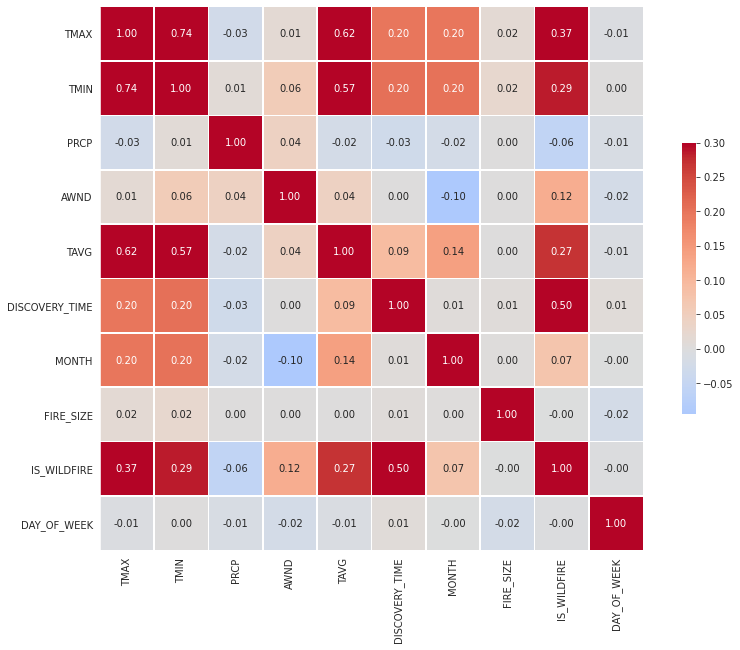

In [1349]:
# Different Visualization ,'TMIN','PRCP','AWND','TAVG','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIRE_SIZE','MONTH','IS_WILDFIRE'
corrmat = dfWeatherAndWildfire[['TMAX','TMIN','PRCP','AWND','TAVG','DISCOVERY_TIME','MONTH','FIRE_SIZE','IS_WILDFIRE','DAY_OF_WEEK']].corr()
g = sns.heatmap(corrmat,  vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)
plt.show()

Lets Create a pair plot for the same

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


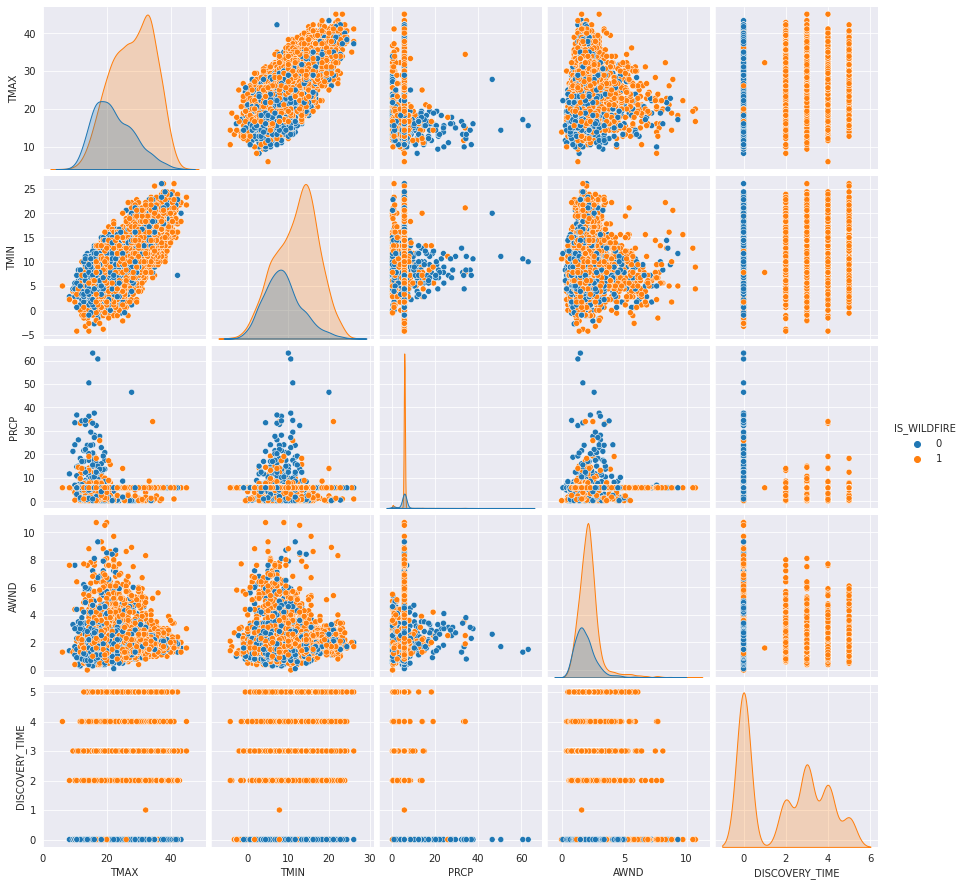

In [1371]:
sns.set_style('darkgrid')
sns.pairplot(dfWeatherAndWildfire[['TMAX','TMIN','PRCP','AWND','DISCOVERY_TIME','IS_WILDFIRE']], hue="IS_WILDFIRE")
plt.show()

# Generating Machine Learning Models

## Generating Test and Train Dataset

In [1351]:
print(dfWeatherAndWildfire.info())
dfWeatherAndWildfire.isna().sum()

dfWeatherAndWildfire.columns
dfWeatherAndWildfire[['Arson',
       'Campfire', 'Children', 'Debris Burning', 'Equipment Use', 'Fireworks',
       'Lightning', 'Miscellaneous', 'Missing/Undefined', 'Powerline',
       'Railroad', 'Smoking', 'Unknown']]=dfWeatherAndWildfire[['Arson',
       'Campfire', 'Children', 'Debris Burning', 'Equipment Use', 'Fireworks',
       'Lightning', 'Miscellaneous', 'Missing/Undefined', 'Powerline',
       'Railroad', 'Smoking', 'Unknown']].astype('int64')
dfWeatherAndWildfire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE               5994 non-null   datetime64[ns]
 1   TMAX               5994 non-null   float64       
 2   TMIN               5994 non-null   float64       
 3   PRCP               5994 non-null   float64       
 4   AWND               5994 non-null   float64       
 5   TAVG               5994 non-null   float64       
 6   DISCOVERY_TIME     5994 non-null   int64         
 7   LATITUDE           5994 non-null   float64       
 8   LONGITUDE          5994 non-null   float64       
 9   STAT_CAUSE_DESCR   5994 non-null   object        
 10  FIRE_SIZE          5994 non-null   float64       
 11  FIRE_SIZE_CLASS    5994 non-null   float64       
 12  MONTH              5994 non-null   int64         
 13  DAY_OF_WEEK        5994 non-null   int64         
 14  IS_WILDF

## Standardization of the training data

In [1398]:
# We will split 80% or data for training and 20% for testing
# Value of the predictors
X = dfWeatherAndWildfire[['TMAX','TMIN','TAVG','PRCP','AWND','MONTH','DAY_OF_WEEK','DISCOVERY_TIME']]

# Target variables
y = dfWeatherAndWildfire['IS_WILDFIRE']

# Creating a test set and training set using sklearn train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33,random_state = 25)

# Fit on training set only.
scaler = StandardScaler()
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Exporting Standard Scalar as well
with open('sc.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [1353]:
print('The shape of the X_train is ', X_train.shape)
print('The shape of the X_test is ', X_test.shape)
print('The shape of the y_train is ', y_train.shape)
print('The shape of the y_test is ', y_test.shape)

The shape of the X_train is  (4015, 8)
The shape of the X_test is  (1979, 8)
The shape of the y_train is  (4015,)
The shape of the y_test is  (1979,)


In [1354]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross Validation for various ML Models

In [1372]:
# Importing various models for Crossvalidation Evaluation
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initiating SVC Model
svc = SVC(degree=3, gamma='scale')

# Initiating LinearSVC Model
linearSVC = LinearSVC(max_iter=10000, dual=True)

# Initiating GaussianNB Model
gnb = GaussianNB()

# Initiating Decision Tree Model
dTreeClass = DecisionTreeClassifier()

# Initiating KNN Classifier. n_neighbors=2 as we already know that this is a binary classification problem
knn = KNeighborsClassifier(n_neighbors=2)

# Initiating Logistic Regression Model
logReg = LogisticRegression()

RFC = RandomForestClassifier(n_estimators=200, max_depth=90)

In [1377]:
kfold = KFold(n_splits=10)

svm_results = cross_val_score(svc, X, y, cv = kfold)
linearsvc_results = cross_val_score(linearSVC, X, y, cv = kfold)
gaussian_results = cross_val_score(gnb, X, y, cv = kfold)
dec_results = cross_val_score(dTreeClass, X, y, cv = kfold)
knn_results = cross_val_score(knn, X, y, cv = kfold)
logreg_results = cross_val_score(logReg, X, y, cv = kfold)

print('SVM Avg Accuracy', svm_results.mean()*100)
print('Linear SVC Avg Accuracy', linearsvc_results.mean()*100)
print('Gaussian NB Avg Accuracy', gaussian_results.mean()*100)
print('Decision Tree Avg Accuracy', dec_results.mean()*100)
print('KNN Avg Accuracy', knn_results.mean()*100)
print('Logistic Regression Avg Accuracy', logreg_results.mean()*100)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

SVM Avg Accuracy 81.68333333333334
Linear SVC Avg Accuracy 81.43322203672788
Gaussian NB Avg Accuracy 70.07640511964384
Decision Tree Avg Accuracy 77.06302170283806
KNN Avg Accuracy 74.67815804117974
Logistic Regression Avg Accuracy 81.2664162493044


**As we can see that the accuracy for all the models are coming up to 81.75 percent. As this is a binary classification scenario, most of the algorithms are performing well.**

### Model Evaluation Utility

In [1374]:
# For dumping the model
import pickle

def model_utility(modelIns, modelName ,X_train, y_train, X_test, y_test):
  print('======================================================')
  print('============',modelName,'====================')
  model = modelIns.fit(X_train,y_train)
  y_predict = model.predict(X_test)

  # Creating Confusion Matrix
  cm = np.array(confusion_matrix(y_test, y_predict))
  print(cm)
  plot_confusion_matrix(confusion_matrix(y_test, y_predict), classes=['FAKE', 'REAL'])
  confusion = pd.DataFrame(cm)

  # Print Confusion Matrix Score
  print('\n\n')
  print('Confusion Matrix')
  print(confusion)
  print('\n\n')

  # Print Accuracy Score
  print('Accuracy :',accuracy_score(y_test, y_predict))
  print('\n\n')
  print(X_test[3])
  #print(np.where(y_predict==0))
  
  # Classification Report
  print('Classification Report :')
  print(classification_report(y_test,y_predict))

  print('\n\n')
  print('Generating Models Pickle File......')
  pkl_filename = "pickle_model.pkl"
  with open(modelName+'.pkl', 'wb') as file:
    pickle.dump(model, file)
  print('Done! Please find the model file', modelName+'.joblib')
  print('======================================================')

## Support Vector Machine

### Support Vector Classifier

============ Support Vector Classifier ====================
[[ 395  148]
 [ 186 1250]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  395   148
1  186  1250



Accuracy : 0.8312278928751895



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       543
           1       0.89      0.87      0.88      1436

    accuracy                           0.83      1979
   macro avg       0.79      0.80      0.79      1979
weighted avg       0.84      0.83      0.83      1979




Generating Models Pickle File......
Done! Please find the model file Support Vector Classifier.joblib


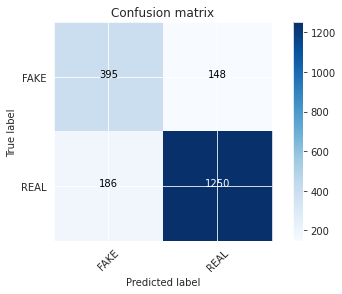

In [1402]:
# Fitting the SVC Model from suport Vector
model_utility(svc,'Support Vector Classifier',X_train, y_train, X_test, y_test)

### Linear Suport Vector Classifier

============ Linear SVC ====================
[[ 381  162]
 [ 196 1240]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  381   162
1  196  1240



Accuracy : 0.8191005558362809



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       543
           1       0.88      0.86      0.87      1436

    accuracy                           0.82      1979
   macro avg       0.77      0.78      0.78      1979
weighted avg       0.82      0.82      0.82      1979




Generating Models Pickle File......
Done! Please find the model file Linear SVC.joblib


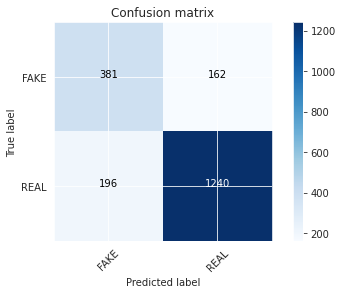

In [1376]:
model_utility(linearSVC,'Linear SVC', X_train, y_train, X_test, y_test)

## Guassian NB

============ Guassian NB ====================
[[543   0]
 [634 802]]
Confusion matrix, without normalization



Confusion Matrix
     0    1
0  543    0
1  634  802



Accuracy : 0.6796361798888327



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       543
           1       1.00      0.56      0.72      1436

    accuracy                           0.68      1979
   macro avg       0.73      0.78      0.67      1979
weighted avg       0.85      0.68      0.69      1979




Generating Models Pickle File......
Done! Please find the model file Guassian NB.joblib


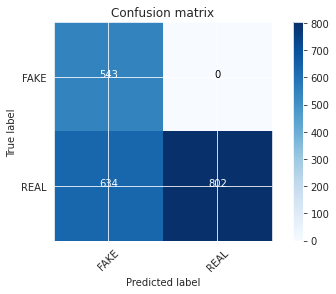

In [1361]:
model_utility(gnb,'Guassian NB', X_train, y_train, X_test, y_test)

## Decision Tree

============ Decision Tree ====================
[[ 333  210]
 [ 254 1182]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  333   210
1  254  1182



Accuracy : 0.7655381505811015



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       543
           1       0.85      0.82      0.84      1436

    accuracy                           0.77      1979
   macro avg       0.71      0.72      0.71      1979
weighted avg       0.77      0.77      0.77      1979




Generating Models Pickle File......
Done! Please find the model file Decision Tree.joblib


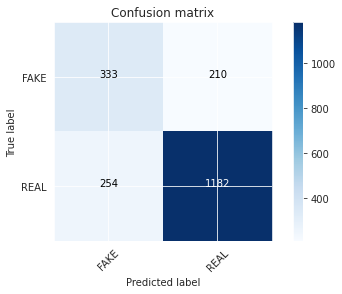

In [1362]:
model_utility(dTreeClass,'Decision Tree', X_train, y_train, X_test, y_test)

## KNN

============ KNN ====================
[[ 443  100]
 [ 373 1063]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  443   100
1  373  1063



Accuracy : 0.7609903991915109



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.54      0.82      0.65       543
           1       0.91      0.74      0.82      1436

    accuracy                           0.76      1979
   macro avg       0.73      0.78      0.73      1979
weighted avg       0.81      0.76      0.77      1979




Generating Models Pickle File......
Done! Please find the model file KNN.joblib


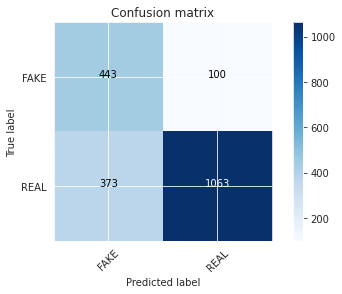

In [1363]:
model_utility(knn,'KNN', X_train, y_train, X_test, y_test)

## Logisitc Regression

============ Random Forest Classifier ====================
[[ 382  161]
 [ 197 1239]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  382   161
1  197  1239



Accuracy : 0.8191005558362809



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       543
           1       0.89      0.86      0.87      1436

    accuracy                           0.82      1979
   macro avg       0.77      0.78      0.78      1979
weighted avg       0.82      0.82      0.82      1979




Generating Models Pickle File......
Done! Please find the model file Random Forest Classifier.joblib


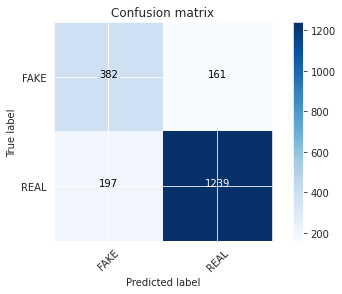

In [1364]:
model_utility(logReg,'Random Forest Classifier', X_train, y_train, X_test, y_test)

============ Logistic Regression ====================
[[ 398  145]
 [ 198 1238]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  398   145
1  198  1238



Accuracy : 0.8266801414855988



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       543
           1       0.90      0.86      0.88      1436

    accuracy                           0.83      1979
   macro avg       0.78      0.80      0.79      1979
weighted avg       0.83      0.83      0.83      1979




Generating Models Pickle File......
Done! Please find the model file Logistic Regression.joblib


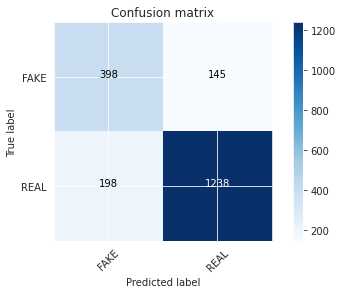

In [1365]:
model_utility(RFC,'Logistic Regression', X_train, y_train, X_test, y_test)

In [1366]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}
# Create a based model
rf = RandomForestClassifier(random_state=1)

# Instantiate the grid search model
rfModel = grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

from pprint import pprint


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       543
           1       0.90      0.87      0.88      1436

    accuracy                           0.83      1979
   macro avg       0.79      0.80      0.79      1979
weighted avg       0.84      0.83      0.83      1979



array([[ 1.12456381,  0.31645934,  1.5633365 , ...,  0.39212604,
         1.46530754, -0.8080776 ],
       [-0.3569843 ,  0.2031172 ,  0.03020696, ..., -0.18690524,
         0.47034563, -0.8080776 ],
       [-1.1471433 , -0.53360669, -1.3386587 , ...,  1.26067296,
         1.46530754, -0.8080776 ],
       ...,
       [-0.66740391,  0.2031172 , -0.00583487, ...,  1.5501886 ,
         1.46530754, -0.8080776 ],
       [-0.7520638 , -1.57257629, -1.63980915, ..., -1.63448344,
        -0.02713532, -0.8080776 ],
       [ 0.6589344 , -0.62805848, -0.00583487, ..., -0.76593652,
        -1.02209724, -0.8080776 ]])

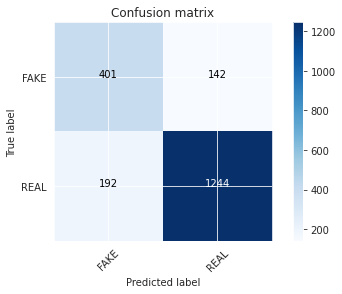

In [1367]:
pprint(rfModel.best_estimator_.get_params())
with open('rf.pkl', 'wb') as file:
    pickle.dump(rfModel, file)
y_predict = rfModel.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_predict), classes=['FAKE', 'REAL'])
print(classification_report(y_test,y_predict))
y_predict
X_test

In [1393]:
# for i in range(len(X_test)):
#   print(rfModel.predict([X_test[i]]))
# y_predict = rfModel.predict(X_test)
X_test[:20]

array([[ 1.12456381,  0.31645934,  1.5633365 ,  0.03479602,  0.07601817,
         0.39212604,  1.46530754, -0.8080776 ],
       [-0.3569843 ,  0.2031172 ,  0.03020696,  0.03479602, -0.02396849,
        -0.18690524,  0.47034563, -0.8080776 ],
       [-1.1471433 , -0.53360669, -1.3386587 , -2.40474353, -1.02383501,
         1.26067296,  1.46530754, -0.8080776 ],
       [-1.37290301, -0.83585239, -0.00583487,  0.03479602,  0.07601817,
         1.26067296,  1.46530754,  0.89444027],
       [ 0.8988041 ,  0.61870504, -0.00583487,  0.03479602,  0.57595143,
        -0.18690524,  0.96782659, -0.8080776 ],
       [ 0.41906471, -0.0991285 , -0.00583487,  0.03479602,  0.17600482,
        -0.76593652,  1.46530754,  1.46194623],
       [-0.0465647 , -1.27033059, -0.7089805 ,  0.03479602,  2.07575121,
         1.5501886 ,  1.46530754,  0.32693432],
       [-0.82261371, -0.94919453, -1.3386587 ,  0.03479602,  2.57568447,
         1.26067296, -1.51957819,  0.89444027],
       [ 0.81414421,  0.84538932

## Conclusion

As we have seen above that the SVM model performs best and gets us the best accuracy. We will go ahead and generate Pickle file for the same in order to persist our model. The utility function above does this task pretty efficiently.

============ sgd ====================
[[ 344  199]
 [ 167 1269]]
Confusion matrix, without normalization



Confusion Matrix
     0     1
0  344   199
1  167  1269



Accuracy : 0.8150581101566448



[-1.37290301 -0.83585239 -0.00583487  0.03479602  0.07601817  1.26067296
  1.46530754  0.89444027]
Classification Report :
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       543
           1       0.86      0.88      0.87      1436

    accuracy                           0.82      1979
   macro avg       0.77      0.76      0.76      1979
weighted avg       0.81      0.82      0.81      1979




Generating Models Pickle File......
Done! Please find the model file sgd.joblib


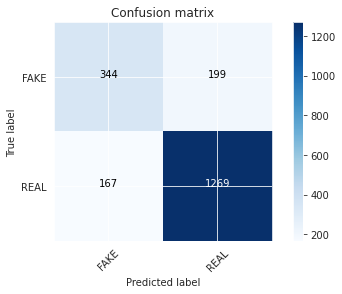

In [1379]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1000, alpha=0.0000000001)
model_utility(clf,'sgd' ,X_train, y_train, X_test, y_test)